### Trainamento do Classificador BERT

In [1]:
import transformers
import torch
import numpy
import pandas
import sklearn
import sklearn.model_selection
import matplotlib

DATASET_PATH = "./datasets/Mental-Health-Twitter-Lemmatized.csv"
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
TRAIN_SIZE = 0.75
MAX_LEN = 200 # Tamanho dos tokens
BATCH_SIZE = 16
EPOCHS = 10 # Número de treinamentos
CLASSIFIER_LABELS = ['non-depressive', 'depressive']

RANDOM_SEED = 42
numpy.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

hardware = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False) 
loss_function = torch.nn.CrossEntropyLoss().to(hardware)

epoch_record = {
    'Train_accuracy': [],
    'Train_loss': [],
    'Validation_accuracy': [],
    'Validation_loss': []
}

df = pandas.read_csv(DATASET_PATH)

df['label'] = df['label'].apply(lambda x: int(x))
df['post_text'] = df['post_text'].apply(lambda x: str(x))

C:\Users\felip\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def _tokenize(self, text):
        return self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]
        encoding = self._tokenize(text)

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

class Classifier(torch.nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.bert = bert_model
        self.drop = torch.nn.Dropout(p=0.3)
        self.out = torch.nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        output = self.drop(pooled_output)
        
        return self.out(output)

def create_data_loader(dataframe, tokenizer, max_length, batch_size):
    dataset = Dataset(
        texts=dataframe.post_text.to_numpy(),
        targets=dataframe.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_length
    )

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size
    )

    return data_loader

def split_data(data, train_size, random_seed):
    return sklearn.model_selection.train_test_split(
        data,
        train_size=train_size,
        random_state=random_seed
    )

df_train, df_temp = split_data(df, train_size=TRAIN_SIZE, random_seed=RANDOM_SEED)
df_val, df_test = split_data(df_temp, train_size=0.5, random_seed=RANDOM_SEED)

print (f'Train dataset shape: {df_train.shape}'
        f'\nValidation dataset shape: {df_val.shape}'
        f'\nTest dataset shape: {df_test.shape}')

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))
print(f'data: {data}')
print(f'data.keys(): {data.keys()}')
print(f'input_ids: {data["input_ids"]}')
print(f'attention_mask: {data["attention_mask"]}')

model = Classifier(len(CLASSIFIER_LABELS)).to(hardware)
print(f'model: {model}')

# optimizer = transformers.AdamW(model.parameters(), lr=0.00002, correct_bias=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00002)

input_ids = data['input_ids'].to(hardware)
attention_mask = data['attention_mask'].to(hardware)

torch.nn.functional.softmax(model(input_ids, attention_mask), dim=1)

total_steps = len(train_data_loader) * EPOCHS
print(f'total_steps: {total_steps}')

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_epoch(model, data_loader, loss_fn, optimizer, hardware, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data["input_ids"].to(hardware)
        attention_mask = data["attention_mask"].to(hardware)
        targets = data["targets"].to(hardware)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double().cpu().numpy() / n_examples, numpy.mean(losses)

def evaluate_model(model, data_loader, loss_fn, hardware, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(hardware)
            attention_mask = data["attention_mask"].to(hardware)
            targets = data["targets"].to(hardware)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double().cpu().numpy() / n_examples, numpy.mean(losses)

def log_and_print_results(phase, accuracy, loss, epoch_record):
    print(f'{phase} loss {loss} accuracy {accuracy}\n')

    epoch_record[f'{phase}_accuracy'].append(accuracy)
    epoch_record[f'{phase}_loss'].append(loss)

Train dataset shape: (15000, 13)
Validation dataset shape: (2500, 13)
Test dataset shape: (2500, 13)
data: {'text': [' @DaveNavarro: Happy the world is so passionate about #CecilTheLion Lets find a global voice for all the animals that HAVEN’T been given …', 'The Text Neck Explosion—and Other Injuries of the Digital Age - via #MASSAGE Magazine ', "Starting the 7 day vegan challenge tomorrow(I'm gonna die)😥", "I wanna ask these people how much this particular saber is going to cost but I'm afraid of getting replies like $1000 or something. ☹️", "@thehill IT AIN'TGONNA Happen!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ", 'Craving vegan pizza soo bad 😍😍😍', 'who the fuck is daleth', ' @SpaceNiggaJesus: welp. ', "Eight years later: The economy and President Obama's legacy  via @nbcnews1 OF A KIND! NEVER SEE  LIKESOFHIM AGAIN!!", "I don't think I can ever handle a LDR.", '@azarkansero *boring', "@areeejthezahid why can't you eat hot cheetos rn?", ' @NFL: TB12. Amazing. #Patriots '

In [4]:
%%time
highest_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}\n{"-" * 10}')

    train_accuracy, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_function,
        optimizer,
        hardware,
        scheduler,
        len(df_train)
    )
    log_and_print_results('Train', train_accuracy, train_loss, epoch_record)

    validation_accuracy, validation_loss = evaluate_model(
        model,
        val_data_loader,
        loss_function,
        hardware,
        len(df_val)
    )   
    log_and_print_results('Validation', validation_accuracy, validation_loss, epoch_record)

    if validation_accuracy > highest_accuracy:
        torch.save(model.state_dict(), 'bert_depressive_model_trained.bin')
        highest_accuracy = validation_accuracy

Epoch 1/10
----------
Train loss 0.37835290242852304 accuracy 0.8190666666666667

Validation loss 0.28117252026156636 accuracy 0.8784

Epoch 2/10
----------
Train loss 0.17532953295278608 accuracy 0.9336

Validation loss 0.384337651036134 accuracy 0.8948

Epoch 3/10
----------
Train loss 0.1049135933925985 accuracy 0.9696666666666667

Validation loss 0.5540364753999184 accuracy 0.8924

Epoch 4/10
----------
Train loss 0.05395893457712472 accuracy 0.9859333333333333

Validation loss 0.5982325363306497 accuracy 0.9016

Epoch 5/10
----------
Train loss 0.030144860815975283 accuracy 0.993

Validation loss 0.6452784363531823 accuracy 0.9092

Epoch 6/10
----------
Train loss 0.01681657641972276 accuracy 0.9961333333333333

Validation loss 0.7625193542482208 accuracy 0.9012

Epoch 7/10
----------
Train loss 0.012833751998719728 accuracy 0.9970666666666667

Validation loss 0.7713707733866416 accuracy 0.908

Epoch 8/10
----------
Train loss 0.009273912240011915 accuracy 0.9980666666666667

Vali

### Display training accuracy result as graphs

epoch_record: {'Train_accuracy': [0.8190666666666667, 0.9336, 0.9696666666666667, 0.9859333333333333, 0.993, 0.9961333333333333, 0.9970666666666667, 0.9980666666666667, 0.9991333333333333, 0.9994], 'Train_loss': [0.37835290242852304, 0.17532953295278608, 0.1049135933925985, 0.05395893457712472, 0.030144860815975283, 0.01681657641972276, 0.012833751998719728, 0.009273912240011915, 0.004180805486893316, 0.0029723312476781214], 'Validation_accuracy': [0.8784, 0.8948, 0.8924, 0.9016, 0.9092, 0.9012, 0.908, 0.908, 0.9032, 0.906], 'Validation_loss': [0.28117252026156636, 0.384337651036134, 0.5540364753999184, 0.5982325363306497, 0.6452784363531823, 0.7625193542482208, 0.7713707733866416, 0.8179737283901561, 0.8516966781593377, 0.8575693573129509]}


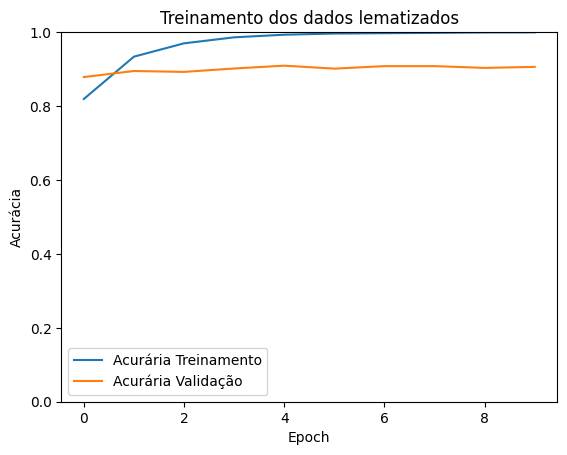

In [7]:
print(f'epoch_record: {epoch_record}')

%matplotlib inline

matplotlib.pyplot.plot(epoch_record['Train_accuracy'], label='Acurária Treinamento')
matplotlib.pyplot.plot(epoch_record['Validation_accuracy'], label='Acurária Validação')
matplotlib.pyplot.title('Treinamento dos dados lematizados')
matplotlib.pyplot.ylabel('Acurácia')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.legend()
matplotlib.pyplot.ylim([0, 1])
matplotlib.pyplot.show()

In [8]:
test_accuracy, _ = evaluate_model(
    model,
    test_data_loader,
    loss_function,
    hardware,
    len(df_test)
)

print(f'Teste de acurária: {test_accuracy.item()}')

Teste de acurária: 0.9072
